In [1]:
# from plotly import __version__
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# print(__version__) # requires version >= 1.9.0
# init_notebook_mode(connected=True)
# iplot([{"x": [1, 2, 3], "y": [3, 1, 6]}])

In [1]:
import os
import math
import random
import numpy as np
from time import time
from collections import Counter
from reconstruction.utils import binvox_rw
from reconstruction.utils.plot import plot_vol
from pprint import pprint

# Check datasets

In [2]:
path = 'ModelNet10/'
labels = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
files = [os.path.join(path,l,'train',ll) for l in labels
         for ll in os.listdir(os.path.join(path, l, 'train'))
         if ll[-4:] == '.off']

print(labels)
files[:10]

['chair']


['ModelNet10/chair\\train\\chair_0001.off',
 'ModelNet10/chair\\train\\chair_0002.off',
 'ModelNet10/chair\\train\\chair_0003.off',
 'ModelNet10/chair\\train\\chair_0004.off',
 'ModelNet10/chair\\train\\chair_0005.off',
 'ModelNet10/chair\\train\\chair_0006.off',
 'ModelNet10/chair\\train\\chair_0007.off',
 'ModelNet10/chair\\train\\chair_0008.off',
 'ModelNet10/chair\\train\\chair_0009.off',
 'ModelNet10/chair\\train\\chair_0010.off']

# read / convert / plot


Plotting: ModelNet10/chair\train\chair_0384.off


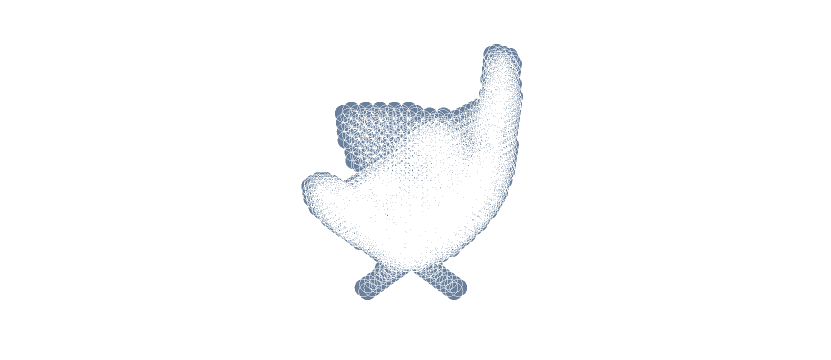

In [6]:
# generate file
file = random.choice(files)

def check_fix_file(file):
    with open(file) as f:
        l1 = f.readline()
        l2 = f.readlines()

    if l1 != 'OFF\n' and l1[:3] == 'OFF':
        out = 'OFF\n'
        out += l1.split('OFF')[1]
        out += ''.join(l2)
        with open(file, 'w') as f:
            f.write(out)

def voxels_from_file(file, voxsize):
    cmd = f'/Users/arone/OneDrive/Escritorio/Trabajo-Machine-Learning/TA-2/binvox/binvox -d {voxsize} -cb -e {file}'
    check_fix_file(file)
    out_file = file.split('.')[0] + '.binvox'
            
    if os.path.exists(out_file):
        os.remove(out_file)

    t = os.system(cmd)
    
    if t == 0:
        with open(out_file, 'rb') as f:
            d = binvox_rw.read_as_3d_array(f).data
        
        os.remove(out_file)
        return 1, d
    else:
        return 0, None

voxels = voxels_from_file(file, 32)
print('\nPlotting:', file)
plot_vol(voxels[1])

# Convert all ModelNet

In [7]:
import multiprocessing
from concurrent.futures import ThreadPoolExecutor

def multithreading(func, args, workers):
    with ThreadPoolExecutor(max_workers=workers) as executor:
        res = executor.map(func, args)
    return list(res)

get_label = lambda x: x.split('ModelNet')[1][3:].split('/')[0]

def get_voxels(files, voxsize):
    data = np.ndarray((0, *[voxsize]*3), dtype=np.bool)
    labels = []
    errors = []
    
    for i, file in enumerate(files):
        res = voxels_from_file(file, voxsize)
        if res[0] == 1:
            labels.append(get_label(file))
            data = np.vstack([data, res[1].reshape((1, *res[1].shape))])
        else:
            errors.append(file)

    return labels, data, errors

get_voxels_parallel = lambda x: get_voxels(*x)

def convert_all(path, voxsize):
    out_file = os.path.join(path, 'voxels.npy')
    labels = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    train_files = [os.path.join(path,l,'train',ll) for l in labels
                   for ll in os.listdir(os.path.join(path, l, 'train'))
                   if ll[-4:] == '.off']
    test_files = [os.path.join(path,l,'test',ll) for l in labels
                   for ll in os.listdir(os.path.join(path, l, 'test'))
                   if ll[-4:] == '.off']

    print(f'train: {len(train_files)}, test: {len(test_files)}')
    
    n_cpu = multiprocessing.cpu_count()
    output = {}
    
    for data_files, data_name in zip([train_files, test_files], ['train', 'test']):
        t0 = time()
        print(f'Launching {n_cpu} threads for {data_name} set...', end='')
        thread_size = math.ceil(len(data_files) / n_cpu)
        args = [(data_files[i*thread_size:(i+1)*thread_size], voxsize) for i in range(n_cpu)]
        res = multithreading(get_voxels_parallel, args, n_cpu)
        labels = []
        data = np.ndarray((0, *[voxsize]*3), dtype=np.bool)
        errors = []

        for l, d, e in res:
            labels += l
            data = np.vstack([data, d])
            errors += e
            
        output[data_name] = {'labels': labels, 'data': data, 'errors': errors}
        
        print('(%.2fs)' % (time() - t0))
    
    np.save(out_file, output)    
    print('\nSaved on: %s (%.2fM)' % (out_file, os.path.getsize(out_file) / 1024**2))

In [8]:
convert_all('ModelNet10/', voxsize=32)

train: 889, test: 100
Launching 8 threads for train set...

C:\Users\arone\AppData\Local\Temp\ipykernel_88048\4063895973.py:12: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\arone\AppData\Local\Temp\ipykernel_88048\4063895973.py:50: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



(48.41s)
Launching 8 threads for test set...(5.64s)

Saved on: ModelNet10/voxels.npy (30.94M)


chair\train\chair_0309.off


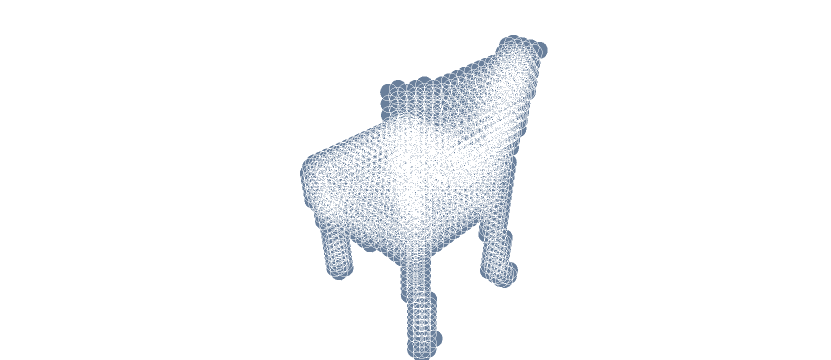

In [9]:
modelnet10 = np.load('ModelNet10/voxels.npy',allow_pickle=True).item()
idx = random.choice(range(len(modelnet10['train']['labels'])))
print(modelnet10['train']['labels'][idx])
plot_vol(modelnet10['train']['data'][idx])